In [ ]:
# import tensorflow as tf
# from keras.datasets import cifar100
# from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda, Conv2D, MaxPool2D, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow import keras
# import numpy as np
# from tensorflow.keras.utils import plot_model
# import datetime, os
# import time
# import pandas as pd
# import seaborn as sns
# from tensorflow.keras.applications import VGG19

# %load_ext tensorboard

In [1]:
from deakin.edu.au.data import Cifar100
import deakin.edu.au.models as models
import deakin.edu.au.metrics as metrics
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from graphviz import Digraph
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np
from sklearn.metrics import accuracy_score
from keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19


%load_ext autoreload
%autoreload 2
%load_ext tensorboard


In [2]:
#Load dataset
dataset = Cifar100()
num_classes = [dataset.num_classes_l0, dataset.num_classes_l1, dataset.num_classes_l2]
u = dataset.draw_taxonomy()
u.view()

# Set variables
batch = 128
epochs = 100
# VGG-19
conv_base = 'vgg19'
learning_rate=1e-5
# NIN
# conv_base = 'nin'
# learning_rate=1e-3

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
performance_callback = models.performance_callback(dataset.X_val, dataset.y_val, dataset.taxonomy)

checkpoint_filepath = '/tmp/checkpoint_new'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# Training all models

Model: "mnets"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_base0 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base1 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base2 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
______________________________________________________________________________________________

391/391 [==============================] - 35s 89ms/step - loss: 1.0879 - out_level_0_loss: 0.1255 - out_level_1_loss: 0.9420 - out_level_2_loss: 2.1962 - out_level_0_accuracy: 0.9530 - out_level_1_accuracy: 0.6960 - out_level_2_accuracy: 0.4558 - val_loss: 1.2760 - val_out_level_0_loss: 0.2298 - val_out_level_1_loss: 1.2102 - val_out_level_2_loss: 2.3881 - val_out_level_0_accuracy: 0.9182 - val_out_level_1_accuracy: 0.6236 - val_out_level_2_accuracy: 0.4184
----------------------------------------------------------------------------------------------------
epoch=8, Exact Match = 0.3472, accuracy level_0 = 0.9182, accuracy level_1 = 0.6236, accuracy level_2 = 0.4184, Consistency = 0.5754
----------------------------------------------------------------------------------------------------

Epoch 9/100
391/391 [==============================] - 35s 89ms/step - loss: 0.9666 - out_level_0_loss: 0.0938 - out_level_1_loss: 0.8483 - out_level_2_loss: 1.9576 - out_level_0_accuracy: 0.9658 - out

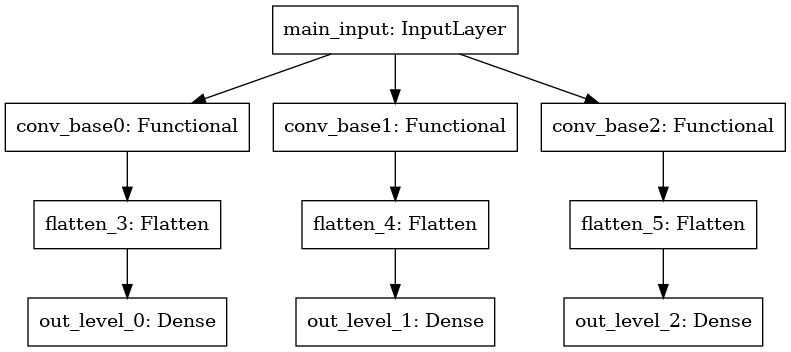

In [5]:
# Create the model
mnets_model = models.get_mnets(num_classes, 
                               dataset.image_size, 
                               reverse=True, 
                               conv_base=conv_base,
                               learning_rate=learning_rate)
mnets_model.summary()
#train model
history_mnets_model = mnets_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(mnets_model)


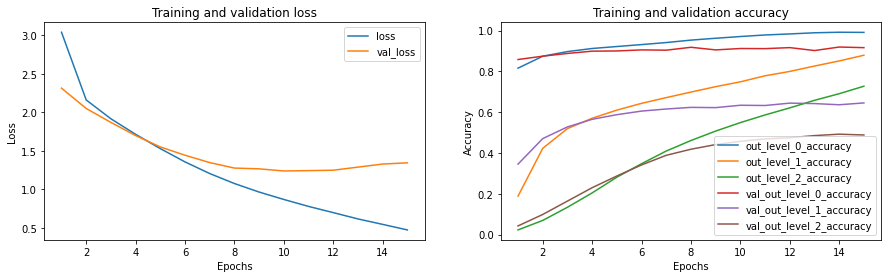

In [6]:
plt.figure(figsize=(15,4))
ax1 = plt.subplot(1, 2, 1)
for l in history_mnets_model.history:
    if l == 'loss' or l == 'val_loss':  
        loss = history_mnets_model.history[l]
        plt.plot(range(1, len(loss) + 1), loss, label=l)
        
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
for k in history_mnets_model.history:
    if 'accuracy' in k:  
        loss = history_mnets_model.history[k]
        plt.plot(range(1, len(loss) + 1), loss, label=k)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
mnets_model_pred = mnets_model.predict(dataset.X_test)
mnets_model_pred = models.get_pred_indexes(mnets_model_pred)
mnets_model_accuracy = metrics.get_taxonomical_accuracy(mnets_model_pred, dataset.y_test)
mnets_model_accuracy = [x * 100 for x in mnets_model_accuracy]


In [8]:
def get_potential_improvement(pred_y, true_y, taxo):
    oracle_accuracy1 = [0] * len(pred_y)
    oracle_accuracy2 = [0] * len(pred_y)
    oracle_accuracy = [0] * len(pred_y)
    for i in range(len(pred_y)):
        for j in range(len(pred_y[0])):
            # check correctness
            if pred_y[i][j] == true_y[i][j][0]:
                continue
            else:
                # go left to right
                stop = False
                for z in range(i+1, len(pred_y)):
                    if pred_y[z][j] == true_y[z][j][0]:
                        oracle_accuracy[i] = oracle_accuracy[i] + 1
                        oracle_accuracy1[i] = oracle_accuracy1[i] + 1
                        stop = True
                        break
                #go right to left -- do not touch, complex code 
                if stop == False and i > 0:
                    parents = []
                    current = pred_y[i][j]
                    for z in reversed(range(i)):
                        m = taxo[z]
                        row = list(np.transpose(m)[current])
                        parent = row.index(1)
                        current = parent
                        parents.insert(0, parent)
                    for z in reversed(range(i)):
                        if pred_y[z][j] == true_y[z][j][0] and true_y[z][j][0] != parents[z]:
                            oracle_accuracy[i] = oracle_accuracy[i] + 1
                            oracle_accuracy2[i] = oracle_accuracy2[i] + 1
                            break
    
    print("Total improvement: ",oracle_accuracy)
    print("Left to right improvement: ",oracle_accuracy1)
    print("Right to left improvement: ",oracle_accuracy2)
    oracle_accuracy  = [x*100/len(mnets_model_pred[0]) for x in oracle_accuracy] 
    return oracle_accuracy


# Testings
# taxo = [[[1, 1, 0, 0, 0], [0, 0, 1, 1, 1]],
#             [[1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0],
#              [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1]]
#             ]
# pred = [np.array([0]), np.array([1]),np.array([2])]
# true_y = [np.array([[0]]), np.array([[0]]),np.array([[0]])]
# get_potential_improvement(pred, true_y, taxo)

# oracle_accuracy = get_potential_improvement(mnets_model_pred,
#                                             dataset.y_test, 
#                                             dataset.taxonomy)



Total improvement:  [192, 484, 760]
Left to right improvement:  [192, 373, 0]
Right to left improvement:  [0, 111, 760]


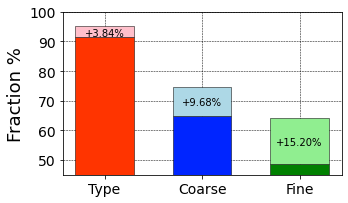

In [11]:
oracle_accuracy = get_potential_improvement(mnets_model_pred,
                                            dataset.y_test, 
                                            dataset.taxonomy)

labels = ['Type', 'Coarse', 'Fine']
width  = 0.6
params = {'legend.fontsize': 10,
          'axes.labelsize': 18,
          'axes.titlesize': 11,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'axes.titlepad': 12}
plt.rcParams.update(params)

fig, ax = plt.subplots(figsize=(5,3))
ax.set_axisbelow(True)
ax.bar(labels, mnets_model_accuracy, width, edgecolor = 'black', linewidth = 0.5, color=['#FF3400','#0025FF','#008000','#FFFD07'])
ax.bar(labels, oracle_accuracy, width,  bottom=mnets_model_accuracy, edgecolor = 'black', linewidth = 0.5, color=['#FFC0CB','#ADD8E6','#90EE90','#FFFEE0'])
ax.set_ylabel('Fraction %')
rects = ax.patches
labels = ["+%.2f" % i for i in oracle_accuracy]
labels = [x+"%" for x in labels]

heights = []
for imp, accuracy in zip(oracle_accuracy, mnets_model_accuracy):
    heights.append(accuracy+imp/2)
 

  
for rect, label, height in zip(rects, labels,heights):
    ax.text(rect.get_x() + rect.get_width() / 2, height-2, label,
            ha='center', va='bottom')

plt.yticks([50,60,70,80,90,100])
# ax.set_yticks([0,2,4,6])
ax.set_ylim(45, 100)
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)

plt.savefig('plots/oracle.eps', bbox_inches = 'tight')
plt.show()

Model: "mout_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_29 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_level_0 (Dense)             (None, 2)            1026        flatten_29[0][0]                 
_________________________________________________________________________________________

391/391 [==============================] - 14s 36ms/step - loss: 1.1388 - out_level_0_loss: 0.1612 - out_level_1_loss: 1.1221 - out_level_2_loss: 2.1332 - out_level_0_accuracy: 0.9373 - out_level_1_accuracy: 0.6477 - out_level_2_accuracy: 0.4478 - val_loss: 1.2808 - val_out_level_0_loss: 0.2111 - val_out_level_1_loss: 1.3170 - val_out_level_2_loss: 2.3143 - val_out_level_0_accuracy: 0.9208 - val_out_level_1_accuracy: 0.5996 - val_out_level_2_accuracy: 0.4176
----------------------------------------------------------------------------------------------------
epoch=9, Exact Match = 0.3506, accuracy level_0 = 0.9208, accuracy level_1 = 0.5996, accuracy level_2 = 0.4176, Consistency = 0.6636
----------------------------------------------------------------------------------------------------

Epoch 10/100
391/391 [==============================] - 14s 36ms/step - loss: 1.0550 - out_level_0_loss: 0.1525 - out_level_1_loss: 1.0449 - out_level_2_loss: 1.9676 - out_level_0_accuracy: 0.9407 - ou

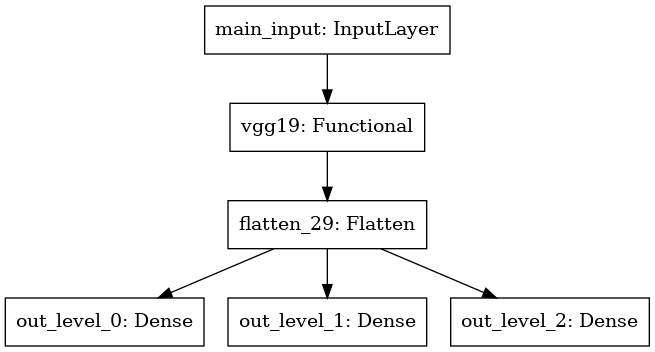

In [205]:
# Create the model
mout_model = models.get_mout_model(num_classes, 
                                   dataset.image_size, 
                                   conv_base=conv_base,
                                   learning_rate=learning_rate)
mout_model.summary()
#train model
history_mout_model = mout_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(mout_model)


Model: "Model_BCNN1_reversed_False"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
_________________________________________________________________
out_level_0 (Dense)          (None, 2)                 1026      
_________________________________________________________________
out_level_1 (Dense)          (None, 20)                60        
_________________________________________________________________
out_level_2 (Dense)          (None, 100)               2100      
Total params: 20,027,570
Trainable params: 20,027,570
Non-trainable params: 0
____________________________

391/391 [==============================] - 13s 34ms/step - loss: 2.5625 - out_level_0_loss: 0.0747 - out_level_1_loss: 3.0075 - out_level_2_loss: 4.6052 - out_level_0_accuracy: 0.9734 - out_level_1_accuracy: 0.0956 - out_level_2_accuracy: 0.0091 - val_loss: 2.6316 - val_out_level_0_loss: 0.2815 - val_out_level_1_loss: 3.0081 - val_out_level_2_loss: 4.6050 - val_out_level_0_accuracy: 0.9154 - val_out_level_1_accuracy: 0.0868 - val_out_level_2_accuracy: 0.0100
----------------------------------------------------------------------------------------------------
epoch=10, Exact Match = 0.0000, accuracy level_0 = 0.9154, accuracy level_1 = 0.0868, accuracy level_2 = 0.0100, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 11/100
391/391 [==============================] - 13s 34ms/step - loss: 2.5569 - out_level_0_loss: 0.0591 - out_level_1_loss: 3.0065 - out_level_2_loss: 4.6051 - out_level_0_accuracy: 0.9784 - o

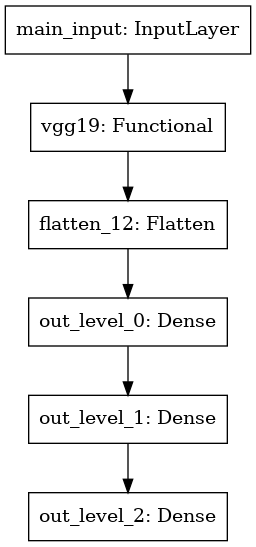

In [17]:
# Create the model
BCNN1_model = models.get_BCNN1(num_classes, 
                               dataset.image_size, 
                               conv_base=conv_base,
                               learning_rate=learning_rate)
BCNN1_model.summary()
#train model
history_BCNN1_model = BCNN1_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN1_model)


Model: "Model_BCNN1_reversed_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
out_level_2 (Dense)          (None, 100)               51300     
_________________________________________________________________
out_level_1 (Dense)          (None, 20)                2020      
_________________________________________________________________
out_level_0 (Dense)          (None, 2)                 42        
Total params: 20,077,746
Trainable params: 20,077,746
Non-trainable params: 0
_____________________________

391/391 [==============================] - 13s 33ms/step - loss: 1.8361 - out_level_0_loss: 0.6913 - out_level_1_loss: 2.9800 - out_level_2_loss: 1.8370 - out_level_0_accuracy: 0.6680 - out_level_1_accuracy: 0.1078 - out_level_2_accuracy: 0.5301 - val_loss: 1.9517 - val_out_level_0_loss: 0.6898 - val_out_level_1_loss: 2.9790 - val_out_level_2_loss: 2.1864 - val_out_level_0_accuracy: 0.6460 - val_out_level_1_accuracy: 0.1106 - val_out_level_2_accuracy: 0.4638
----------------------------------------------------------------------------------------------------
epoch=10, Exact Match = 0.0272, accuracy level_0 = 0.6460, accuracy level_1 = 0.1106, accuracy level_2 = 0.4638, Consistency = 0.0662
----------------------------------------------------------------------------------------------------

Epoch 11/100
391/391 [==============================] - 13s 33ms/step - loss: 1.7811 - out_level_0_loss: 0.6890 - out_level_1_loss: 2.9754 - out_level_2_loss: 1.6790 - out_level_0_accuracy: 0.6553 - o

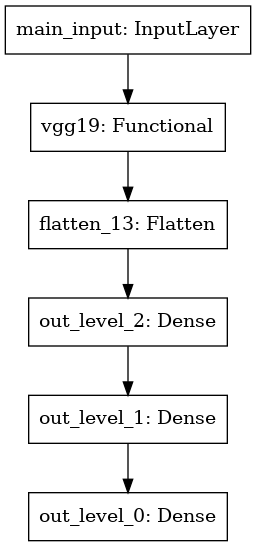

In [19]:
# Create the model
BCNN1_reversed_model = models.get_BCNN1(num_classes, 
                                        dataset.image_size, 
                                        reverse=True, 
                                        conv_base=conv_base, 
                                        learning_rate=learning_rate)
BCNN1_reversed_model.summary()
#train model
history_BCNN1_reversed_model = BCNN1_reversed_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN1_reversed_model)

Model: "Model_BCNN2_reversed_False"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_level_0 (Dense)          (None, 2)            1026        flatten_14[0][0]                 
_________________________________________________________________________

391/391 [==============================] - 13s 33ms/step - loss: 2.3937 - out_level_0_loss: 0.2116 - out_level_1_loss: 2.5865 - out_level_2_loss: 4.3831 - out_level_0_accuracy: 0.9284 - out_level_1_accuracy: 0.1595 - out_level_2_accuracy: 0.0284 - val_loss: 2.4238 - val_out_level_0_loss: 0.2638 - val_out_level_1_loss: 2.6222 - val_out_level_2_loss: 4.3854 - val_out_level_0_accuracy: 0.9060 - val_out_level_1_accuracy: 0.1462 - val_out_level_2_accuracy: 0.0284
----------------------------------------------------------------------------------------------------
epoch=8, Exact Match = 0.0118, accuracy level_0 = 0.9060, accuracy level_1 = 0.1462, accuracy level_2 = 0.0284, Consistency = 0.1096
----------------------------------------------------------------------------------------------------

Epoch 9/100
391/391 [==============================] - 13s 33ms/step - loss: 2.3570 - out_level_0_loss: 0.1975 - out_level_1_loss: 2.5427 - out_level_2_loss: 4.3308 - out_level_0_accuracy: 0.9330 - out

391/391 [==============================] - 14s 35ms/step - loss: 1.9970 - out_level_0_loss: 0.0911 - out_level_1_loss: 2.1460 - out_level_2_loss: 3.7540 - out_level_0_accuracy: 0.9769 - out_level_1_accuracy: 0.2154 - out_level_2_accuracy: 0.0739 - val_loss: 2.3392 - val_out_level_0_loss: 0.3899 - val_out_level_1_loss: 2.6148 - val_out_level_2_loss: 4.0129 - val_out_level_0_accuracy: 0.9054 - val_out_level_1_accuracy: 0.1796 - val_out_level_2_accuracy: 0.0714
----------------------------------------------------------------------------------------------------
epoch=18, Exact Match = 0.0472, accuracy level_0 = 0.9054, accuracy level_1 = 0.1796, accuracy level_2 = 0.0714, Consistency = 0.5560
----------------------------------------------------------------------------------------------------

Epoch 19/100
391/391 [==============================] - 13s 34ms/step - loss: 1.9530 - out_level_0_loss: 0.0916 - out_level_1_loss: 2.0941 - out_level_2_loss: 3.6734 - out_level_0_accuracy: 0.9758 - o

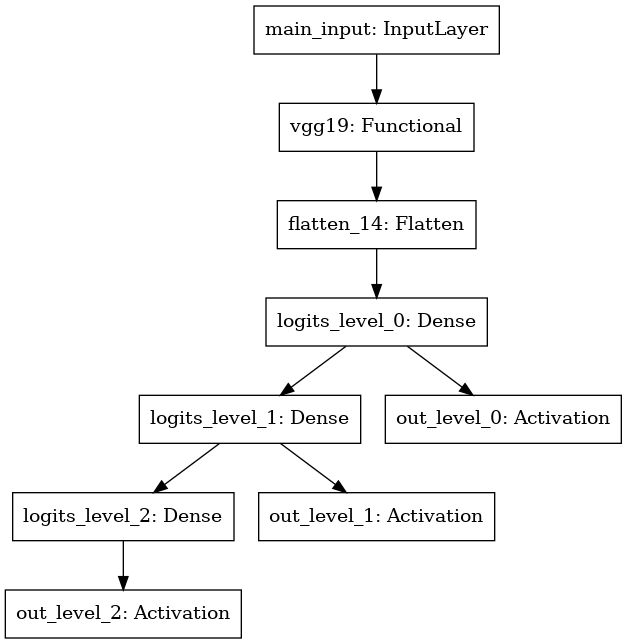

In [20]:
# Create the model
BCNN2_model = models.get_BCNN2(num_classes, 
                               dataset.image_size, 
                               conv_base=conv_base, 
                               learning_rate=learning_rate)
BCNN2_model.summary()
#train model
history_BCNN2_model = BCNN2_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN2_model)

Model: "Model_BCNN2_reversed_True"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_level_2 (Dense)          (None, 100)          51300       flatten_15[0][0]                 
__________________________________________________________________________

391/391 [==============================] - 13s 34ms/step - loss: 1.2487 - out_level_0_loss: 0.1838 - out_level_1_loss: 1.2052 - out_level_2_loss: 2.3571 - out_level_0_accuracy: 0.9316 - out_level_1_accuracy: 0.6293 - out_level_2_accuracy: 0.4249 - val_loss: 1.3671 - val_out_level_0_loss: 0.2216 - val_out_level_1_loss: 1.3877 - val_out_level_2_loss: 2.4921 - val_out_level_0_accuracy: 0.9182 - val_out_level_1_accuracy: 0.5982 - val_out_level_2_accuracy: 0.3868
----------------------------------------------------------------------------------------------------
epoch=8, Exact Match = 0.3314, accuracy level_0 = 0.9182, accuracy level_1 = 0.5982, accuracy level_2 = 0.3868, Consistency = 0.6344
----------------------------------------------------------------------------------------------------

Epoch 9/100
391/391 [==============================] - 13s 34ms/step - loss: 1.1355 - out_level_0_loss: 0.1613 - out_level_1_loss: 1.0914 - out_level_2_loss: 2.1537 - out_level_0_accuracy: 0.9414 - out

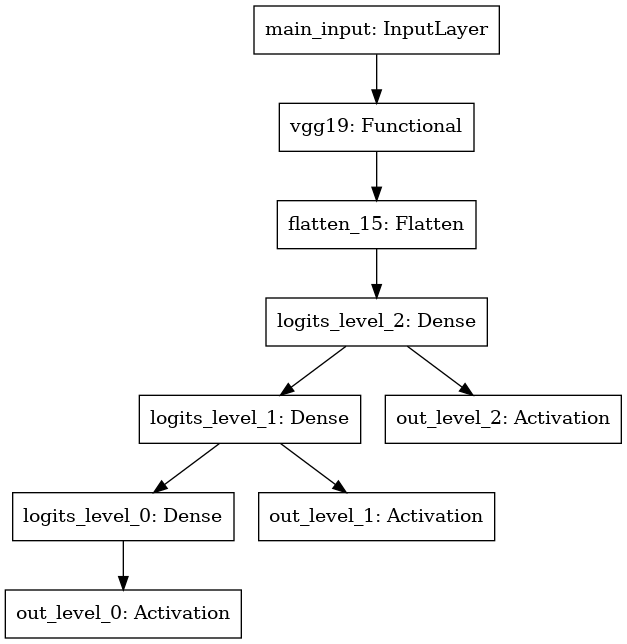

In [21]:
# Create the model
BCNN2_reversed_model = models.get_BCNN2(num_classes, 
                                        dataset.image_size, 
                                        reverse=True, 
                                        conv_base=conv_base,
                                        learning_rate=learning_rate)
BCNN2_reversed_model.summary()
#train model
history_BCNN2_reversed_model = BCNN2_reversed_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN2_reversed_model)


Model: "MLPH_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_1 (Functional)            [(None, None, None,  17664576    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_17 (Flatten)            (None, 2048)         0           model_1[0][0]                    
__________________________________________________________________________________________________
flatten_18 (Flatten)            (None, 2048)         0           model_1[0][1]                    
_________________________________________________________________________________________

----------------------------------------------------------------------------------------------------
epoch=5, Exact Match = 0.0006, accuracy level_0 = 0.6436, accuracy level_1 = 0.0744, accuracy level_2 = 0.0128, Consistency = 0.0330
----------------------------------------------------------------------------------------------------

Epoch 6/100
391/391 [==============================] - 13s 33ms/step - loss: 10.8986 - out_level_0_loss: 2.9548 - out_level_1_loss: 11.9567 - out_level_2_loss: 17.7843 - out_level_0_accuracy: 0.6423 - out_level_1_accuracy: 0.0737 - out_level_2_accuracy: 0.0114 - val_loss: 7.4114 - val_out_level_0_loss: 1.8883 - val_out_level_1_loss: 8.3006 - val_out_level_2_loss: 12.0454 - val_out_level_0_accuracy: 0.6340 - val_out_level_1_accuracy: 0.0700 - val_out_level_2_accuracy: 0.0124
----------------------------------------------------------------------------------------------------
epoch=6, Exact Match = 0.0002, accuracy level_0 = 0.6340, accuracy level_1 = 0.0700,

391/391 [==============================] - 13s 33ms/step - loss: 2.7569 - out_level_0_loss: 0.6113 - out_level_1_loss: 2.9511 - out_level_2_loss: 4.7082 - out_level_0_accuracy: 0.7083 - out_level_1_accuracy: 0.1144 - out_level_2_accuracy: 0.0214 - val_loss: 2.7490 - val_out_level_0_loss: 0.5980 - val_out_level_1_loss: 2.9654 - val_out_level_2_loss: 4.6835 - val_out_level_0_accuracy: 0.7048 - val_out_level_1_accuracy: 0.1248 - val_out_level_2_accuracy: 0.0220
----------------------------------------------------------------------------------------------------
epoch=16, Exact Match = 0.0032, accuracy level_0 = 0.7048, accuracy level_1 = 0.1248, accuracy level_2 = 0.0220, Consistency = 0.0762
----------------------------------------------------------------------------------------------------

Epoch 17/100
391/391 [==============================] - 13s 33ms/step - loss: 2.7229 - out_level_0_loss: 0.5968 - out_level_1_loss: 2.9055 - out_level_2_loss: 4.6664 - out_level_0_accuracy: 0.7160 - o

391/391 [==============================] - 13s 33ms/step - loss: 2.2659 - out_level_0_loss: 0.4445 - out_level_1_loss: 2.3465 - out_level_2_loss: 4.0066 - out_level_0_accuracy: 0.8118 - out_level_1_accuracy: 0.2818 - out_level_2_accuracy: 0.0953 - val_loss: 2.2696 - val_out_level_0_loss: 0.4578 - val_out_level_1_loss: 2.3683 - val_out_level_2_loss: 3.9829 - val_out_level_0_accuracy: 0.8034 - val_out_level_1_accuracy: 0.2776 - val_out_level_2_accuracy: 0.1020
----------------------------------------------------------------------------------------------------
epoch=26, Exact Match = 0.0584, accuracy level_0 = 0.8034, accuracy level_1 = 0.2776, accuracy level_2 = 0.1020, Consistency = 0.3080
----------------------------------------------------------------------------------------------------

Epoch 27/100
391/391 [==============================] - 13s 33ms/step - loss: 2.2218 - out_level_0_loss: 0.4378 - out_level_1_loss: 2.3071 - out_level_2_loss: 3.9206 - out_level_0_accuracy: 0.8150 - o

391/391 [==============================] - 13s 33ms/step - loss: 1.8475 - out_level_0_loss: 0.3576 - out_level_1_loss: 1.9320 - out_level_2_loss: 3.2529 - out_level_0_accuracy: 0.8540 - out_level_1_accuracy: 0.4009 - out_level_2_accuracy: 0.2107 - val_loss: 1.8775 - val_out_level_0_loss: 0.3789 - val_out_level_1_loss: 1.9724 - val_out_level_2_loss: 3.2812 - val_out_level_0_accuracy: 0.8414 - val_out_level_1_accuracy: 0.3996 - val_out_level_2_accuracy: 0.2140
----------------------------------------------------------------------------------------------------
epoch=36, Exact Match = 0.1488, accuracy level_0 = 0.8414, accuracy level_1 = 0.3996, accuracy level_2 = 0.2140, Consistency = 0.4492
----------------------------------------------------------------------------------------------------

Epoch 37/100
391/391 [==============================] - 13s 33ms/step - loss: 1.8080 - out_level_0_loss: 0.3534 - out_level_1_loss: 1.8970 - out_level_2_loss: 3.1736 - out_level_0_accuracy: 0.8573 - o

391/391 [==============================] - 13s 33ms/step - loss: 1.4841 - out_level_0_loss: 0.2824 - out_level_1_loss: 1.5574 - out_level_2_loss: 2.6126 - out_level_0_accuracy: 0.8864 - out_level_1_accuracy: 0.5135 - out_level_2_accuracy: 0.3368 - val_loss: 1.5680 - val_out_level_0_loss: 0.3132 - val_out_level_1_loss: 1.6566 - val_out_level_2_loss: 2.7342 - val_out_level_0_accuracy: 0.8748 - val_out_level_1_accuracy: 0.4948 - val_out_level_2_accuracy: 0.3198
----------------------------------------------------------------------------------------------------
epoch=46, Exact Match = 0.2440, accuracy level_0 = 0.8748, accuracy level_1 = 0.4948, accuracy level_2 = 0.3198, Consistency = 0.5810
----------------------------------------------------------------------------------------------------

Epoch 47/100
391/391 [==============================] - 13s 33ms/step - loss: 1.4423 - out_level_0_loss: 0.2728 - out_level_1_loss: 1.5152 - out_level_2_loss: 2.5389 - out_level_0_accuracy: 0.8918 - o

391/391 [==============================] - 13s 33ms/step - loss: 1.1172 - out_level_0_loss: 0.1872 - out_level_1_loss: 1.1702 - out_level_2_loss: 1.9942 - out_level_0_accuracy: 0.9277 - out_level_1_accuracy: 0.6262 - out_level_2_accuracy: 0.4656 - val_loss: 1.3479 - val_out_level_0_loss: 0.2521 - val_out_level_1_loss: 1.4368 - val_out_level_2_loss: 2.3547 - val_out_level_0_accuracy: 0.9086 - val_out_level_1_accuracy: 0.5606 - val_out_level_2_accuracy: 0.4036
----------------------------------------------------------------------------------------------------
epoch=56, Exact Match = 0.3208, accuracy level_0 = 0.9086, accuracy level_1 = 0.5606, accuracy level_2 = 0.4036, Consistency = 0.6406
----------------------------------------------------------------------------------------------------

Epoch 57/100
391/391 [==============================] - 13s 33ms/step - loss: 1.1012 - out_level_0_loss: 0.1894 - out_level_1_loss: 1.1529 - out_level_2_loss: 1.9612 - out_level_0_accuracy: 0.9257 - o

391/391 [==============================] - 13s 33ms/step - loss: 0.7457 - out_level_0_loss: 0.1056 - out_level_1_loss: 0.7628 - out_level_2_loss: 1.3688 - out_level_0_accuracy: 0.9612 - out_level_1_accuracy: 0.7509 - out_level_2_accuracy: 0.6155 - val_loss: 1.3520 - val_out_level_0_loss: 0.2974 - val_out_level_1_loss: 1.4618 - val_out_level_2_loss: 2.2968 - val_out_level_0_accuracy: 0.9024 - val_out_level_1_accuracy: 0.6006 - val_out_level_2_accuracy: 0.4450
----------------------------------------------------------------------------------------------------
epoch=66, Exact Match = 0.3640, accuracy level_0 = 0.9024, accuracy level_1 = 0.6006, accuracy level_2 = 0.4450, Consistency = 0.6706
----------------------------------------------------------------------------------------------------



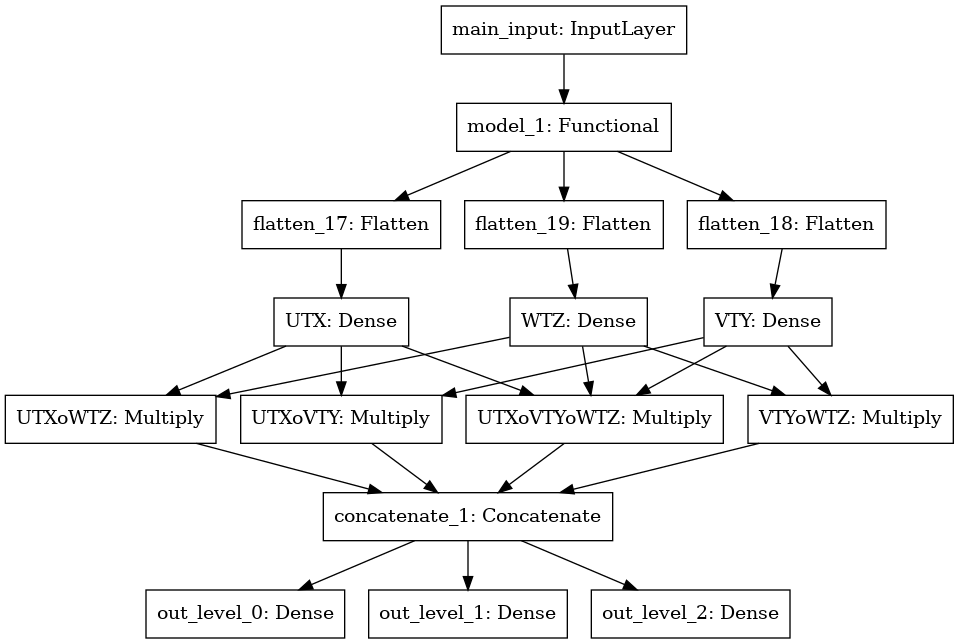

In [23]:
# Create the model
MLPH_model = models.get_MLPH_model(num_classes, dataset.image_size)
MLPH_model.summary()
#train model
history_MLPH_model = MLPH_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(MLPH_model,show_shapes=False, expand_nested=False, dpi=96)



Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_31 (Flatten)         (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,075,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
391/391 [==============================] - 14s 33ms/step - loss: 7.7258 - accuracy: 0.0126 - val_loss: 4.4595 - val_accuracy: 0.0302
---------------------------------------------------------------------------------------------

391/391 [==============================] - 13s 33ms/step - loss: 0.9248 - accuracy: 0.7495 - val_loss: 2.2874 - val_accuracy: 0.4994
----------------------------------------------------------------------------------------------------
epoch=16, Exact Match = 0.4994, accuracy level_0 = 0.9206, accuracy level_1 = 0.6374, accuracy level_2 = 0.4994, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 17/100
391/391 [==============================] - 13s 33ms/step - loss: 0.8011 - accuracy: 0.7809 - val_loss: 2.3438 - val_accuracy: 0.4950
----------------------------------------------------------------------------------------------------
epoch=17, Exact Match = 0.4950, accuracy level_0 = 0.9174, accuracy level_1 = 0.6410, accuracy level_2 = 0.4950, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 18/100
391/391 [=========================

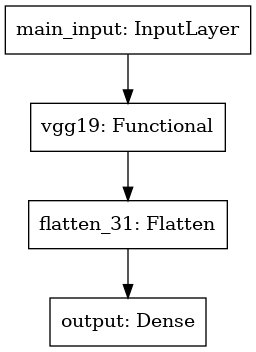

In [245]:
# Create the model
baseline_model = models.get_Baseline_model(num_classes, 
                                           dataset.image_size, 
                                           dataset.taxonomy, 
                                           conv_base=conv_base,
                                           learning_rate=learning_rate)
baseline_model.summary()
#train model
history_baseline_model = baseline_model.fit(dataset.X_train, 
                    dataset.y_train[-1],
                    validation_data = (dataset.X_val, dataset.y_val[-1]),
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(baseline_model)


Model: "Masked_Output_Net"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
main_input (InputLayer)                      [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
vgg19 (Functional)                           (None, None, None, 512)                 20024384       
____________________________________________________________________________________________________
flatten_33 (Flatten)                         (None, 512)                             0              
____________________________________________________________________________________________________
masked__output_5 (Masked_Output)             [(None, 2), (None, 20), (None, 100)]    62586          
Total params: 20,086,970
Trainable params: 20,086,970
Non-traina

391/391 [==============================] - 14s 35ms/step - loss: 1.2736 - masked__output_5_loss: 0.1688 - masked__output_5_1_loss: 1.1414 - masked__output_5_2_loss: 2.5106 - masked__output_5_accuracy: 0.9389 - masked__output_5_1_accuracy: 0.6580 - masked__output_5_2_accuracy: 0.4030 - val_loss: 1.4541 - val_masked__output_5_loss: 0.2139 - val_masked__output_5_1_loss: 1.3301 - val_masked__output_5_2_loss: 2.8183 - val_masked__output_5_accuracy: 0.9212 - val_masked__output_5_1_accuracy: 0.5978 - val_masked__output_5_2_accuracy: 0.3614
----------------------------------------------------------------------------------------------------
epoch=8, Exact Match = 0.3470, accuracy level_0 = 0.9212, accuracy level_1 = 0.5978, accuracy level_2 = 0.3614, Consistency = 0.9156
----------------------------------------------------------------------------------------------------

Epoch 9/100
391/391 [==============================] - 14s 35ms/step - loss: 1.1920 - masked__output_5_loss: 0.1550 - masked_

391/391 [==============================] - 14s 36ms/step - loss: 0.6609 - masked__output_5_loss: 0.0680 - masked__output_5_1_loss: 0.5617 - masked__output_5_2_loss: 1.3529 - masked__output_5_accuracy: 0.9786 - masked__output_5_1_accuracy: 0.8552 - masked__output_5_2_accuracy: 0.6378 - val_loss: 1.4244 - val_masked__output_5_loss: 0.2413 - val_masked__output_5_1_loss: 1.2698 - val_masked__output_5_2_loss: 2.7623 - val_masked__output_5_accuracy: 0.9284 - val_masked__output_5_1_accuracy: 0.6482 - val_masked__output_5_2_accuracy: 0.4524
----------------------------------------------------------------------------------------------------
epoch=17, Exact Match = 0.4402, accuracy level_0 = 0.9284, accuracy level_1 = 0.6482, accuracy level_2 = 0.4524, Consistency = 0.9322
----------------------------------------------------------------------------------------------------

Epoch 18/100
391/391 [==============================] - 14s 35ms/step - loss: 0.6183 - masked__output_5_loss: 0.0605 - maske

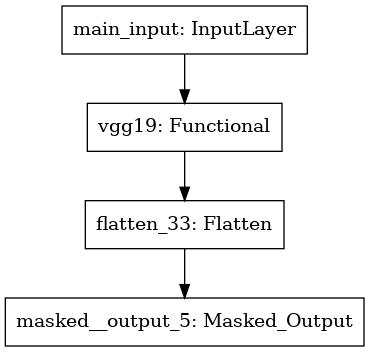

In [247]:
# Create the model
Masked_Output_Net_model = models.get_Masked_Output_Net(num_classes, 
                                                       dataset.image_size, 
                                                       dataset.taxonomy, 
                                                       conv_base=conv_base,
                                                       learning_rate=learning_rate)
Masked_Output_Net_model.summary(line_length=100)

tensorboard = TensorBoard(log_dir='/tmp/logs', histogram_freq=0,
                          write_graph=True, write_images=False)

#train model
history_Masked_Output_Net_model = Masked_Output_Net_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback, tensorboard]
                    )
plot_model(Masked_Output_Net_model)


In [225]:
# Make predictions on the test set
mout_pred = mout_model.predict(dataset.X_test)
BCNN1_pred = BCNN1_model.predict(dataset.X_test)
BCNN1_reversed_pred = BCNN1_reversed_model.predict(dataset.X_test)
BCNN2_pred = BCNN2_model.predict(dataset.X_test)
BCNN2_reversed_pred = BCNN2_reversed_model.predict(dataset.X_test)
mnets_model_pred = mnets_model.predict(dataset.X_test)
baseline_model_pred = baseline_model.predict(dataset.X_test)
MLPH_pred = MLPH_model.predict(dataset.X_test)
Masked_Output_Net_pred = Masked_Output_Net_model.predict(dataset.X_test)


In [226]:
exact_match_scores = [metrics.get_exact_match(dataset.y_test, mout_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN1_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN1_reversed_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN2_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN2_reversed_pred),
                      metrics.get_exact_match(dataset.y_test, mnets_model_pred),
                      metrics.get_exact_match(dataset.y_test, baseline_model_pred),
                      metrics.get_exact_match(dataset.y_test, MLPH_pred),
                      metrics.get_exact_match(dataset.y_test, Masked_Output_Net_pred)]

h_accuracy_scores = [metrics.get_h_accuracy(dataset.y_test, mout_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_reversed_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred),
                     metrics.get_h_accuracy(dataset.y_test, mnets_model_pred),
                     metrics.get_h_accuracy(dataset.y_test, baseline_model_pred), 
                     metrics.get_h_accuracy(dataset.y_test, MLPH_pred), 
                     metrics.get_h_accuracy(dataset.y_test, Masked_Output_Net_pred)]

h_accuracy_scores_k2 = [metrics.get_h_accuracy(dataset.y_test, mout_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_reversed_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, mnets_model_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, baseline_model_pred, k=2), 
                     metrics.get_h_accuracy(dataset.y_test, MLPH_pred, k=2), 
                     metrics.get_h_accuracy(dataset.y_test, Masked_Output_Net_pred, k=2)]

h_accuracy_scores_k5 = [metrics.get_h_accuracy(dataset.y_test, mout_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_reversed_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, mnets_model_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, baseline_model_pred, k=5), 
                     metrics.get_h_accuracy(dataset.y_test, MLPH_pred, k=5), 
                     metrics.get_h_accuracy(dataset.y_test, Masked_Output_Net_pred, k=5)]

m_accuracy_scores = [metrics.get_m_accuracy(dataset.y_test, mout_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN1_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN1_reversed_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN2_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN2_reversed_pred),
                     metrics.get_m_accuracy(dataset.y_test, mnets_model_pred),
                     metrics.get_m_accuracy(dataset.y_test, baseline_model_pred),
                     metrics.get_m_accuracy(dataset.y_test, MLPH_pred),
                     metrics.get_m_accuracy(dataset.y_test, Masked_Output_Net_pred)]


consistency = [metrics.get_consistency(mout_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN1_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN1_reversed_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN2_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN2_reversed_pred, dataset.taxonomy),
               metrics.get_consistency(mnets_model_pred, dataset.taxonomy),
               metrics.get_consistency(baseline_model_pred, dataset.taxonomy),
               metrics.get_consistency(MLPH_pred, dataset.taxonomy),
               metrics.get_consistency(Masked_Output_Net_pred, dataset.taxonomy)]

# Create example dataframe
df = pd.DataFrame({
'exact_match': exact_match_scores,
'h_accuracy': h_accuracy_scores,
'h_accuracy_k2': h_accuracy_scores_k2,
'h_accuracy_k5': h_accuracy_scores_k5,
'm_accuracy': m_accuracy_scores,
'consistency': consistency,
's': [3000,3000,3000,3000,3000,3000,3000,3000,3000],
'algo': ['mout','BCNN1','BCNN1_R','BCNN2','BCNN2_R', 'mnets', 'baseline', 'MLPH', 'Masked_Output_Net']
})


/home/reda/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


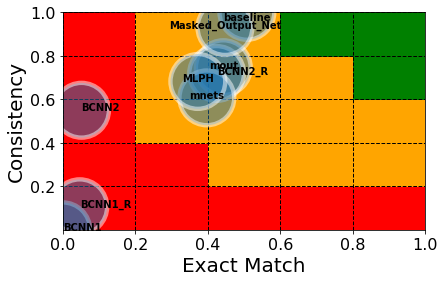

In [223]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.exact_match, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Exact Match')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_em.pdf', bbox_inches = 'tight')
plt.show()


/home/reda/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


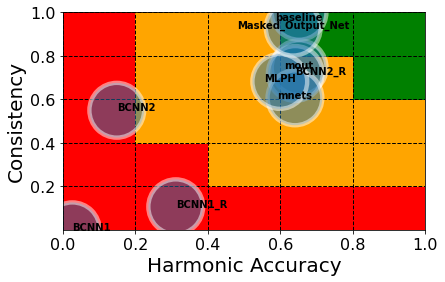

In [211]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy.pdf', bbox_inches = 'tight')
plt.show()


/home/reda/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


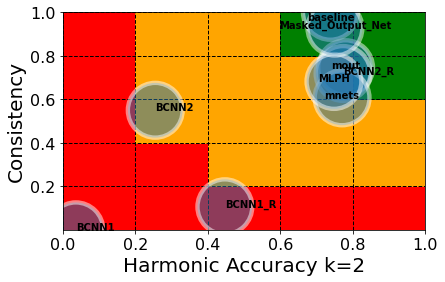

In [215]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy_k2, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy k=2')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy_k2.pdf', bbox_inches = 'tight')
plt.show()


/home/reda/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


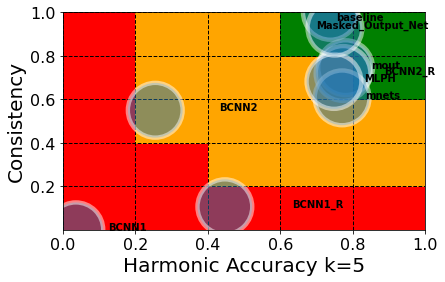

In [217]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy_k2, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy k=5')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy_k5.pdf', bbox_inches = 'tight')
plt.show()


/home/reda/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


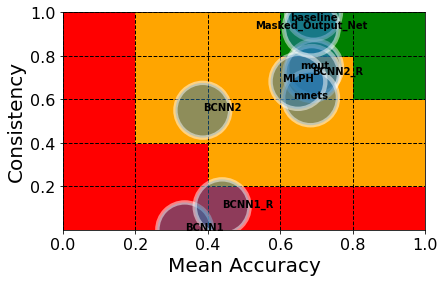

In [212]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.m_accuracy, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Mean Accuracy')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_m_accuracy.pdf', bbox_inches = 'tight')
plt.show()


In [213]:
data = pd.DataFrame(columns=['algo','consistency2'])

data_list = list(zip(['XXX']*len(consistency2), consistency2))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency2']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency2", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")
plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

NameError: name 'consistency2' is not defined

In [ ]:
data = pd.DataFrame(columns=['algo','consistency3'])

data_list = list(zip(['XXX']*len(consistency3), consistency3))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency3']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency3", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")
plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency'])

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi1, X_test, y_test)
# data_list = list(zip(['model1_pi1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi0, X_test, y_test)
# data_list = list(zip(['model1_pi0']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi0_5, X_test, y_test)
data_list = list(zip(['model1_pi0.5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model2, X_test, y_test)
# data_list = list(zip(['model2']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model3, X_test, y_test)
# data_list = list(zip(['model3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model4, X_test, y_test)
# data_list = list(zip(['model4']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model5, X_test, y_test)
data_list = list(zip(['model5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model6, X_test, y_test)
data_list = list(zip(['model6']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)


accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)





accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8, X_test, y_test)
data_list = list(zip(['model8']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8_c_to_f, X_test, y_test)
data_list = list(zip(['model8_c_to_f']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8_f_to_c, X_test, y_test)
data_list = list(zip(['model8_f_to_c']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)


In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.3, 0.52)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_c", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_c")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 0.85)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_f", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_f")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.4, 0.55)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("accuracy_consistency")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.65, 0.85)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 1.)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()


In [ ]:
plt.figure(figsize=(15,4))
ax1 = plt.subplot(1, 2, 1)
for l in history_MLPH_model.history:
    if l == 'loss' or l == 'val_loss':  
        loss = history_MLPH_model.history[l]
        plt.plot(range(1, len(loss) + 1), loss, label=l)
        
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
for k in history_MLPH_model.history:
    if 'accuracy' in k:  
        loss = history_MLPH_model.history[k]
        plt.plot(range(1, len(loss) + 1), loss, label=k)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [227]:
df

,exact_match,h_accuracy,h_accuracy_k2,h_accuracy_k5,m_accuracy,consistency,s,algo
0,0.4428,0.651859,0.779966,0.890073,0.694333,0.7456,3000,mout
1,0.0000,0.026549,0.036204,0.124584,0.336467,0.0000,3000,BCNN1
2,0.0470,0.311629,0.447072,0.631428,0.439600,0.1060,3000,BCNN1_R
3,0.0518,0.149096,0.255173,0.431899,0.386333,0.5498,3000,BCNN2
4,0.4244,0.641310,0.772955,0.885653,0.686533,0.7190,3000,BCNN2_R
5,0.3974,0.640301,0.770308,0.883017,0.683400,0.6068,3000,mnets
6,0.5078,0.651571,0.737062,0.819762,0.691533,1.0000,3000,baseline
7,0.3726,0.598553,0.747899,0.875260,0.648600,0.6822,3000,MLPH
8,0.4474,0.623076,0.743929,0.847396,0.675133,0.9300,3000,Masked_Output_Net
